# waveform.ipynb: 处理波形

In [1]:
from numba import jit
import numpy as np
import h5py
import matplotlib.pyplot as plt
import torch
import joblib
from sklearn import preprocessing
%matplotlib inline
from sklearn import ensemble
from utils import loadData
from sklearn.neural_network import MLPRegressor
from utils import loadData, getNum, getPePerWF, saveData, saveans, wavelet_denoising
from tqdm import tqdm
import graphviz
import lightgbm as lgb

指定__测试集__，__训练集__，__几何文件__的位置

In [2]:
testpath = "./data/final.h5"
trainpath = "./data/final-2.h5"
geopath = "./data/geo.h5"

读取__训练集__：

In [3]:
trainPET, trainWF, trainPT = loadData(trainpath, 'PT')

Structure of data:
<HDF5 dataset "PETruth": shape (9137011,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (6041164,), type "|V2008"> Waveform /Waveform


读取__测试集__，这里只读取Waveform

In [4]:
testWF = loadData(testpath, 'test')

Structure of data:
<HDF5 dataset "Waveform": shape (12178193,), type "|V2008"> Waveform /Waveform


In [55]:
geo = loadData(geopath, 'geo')[:17612]
print(geo[13]['theta'])

Structure of data:
<HDF5 dataset "Geometry": shape (43212,), type "|V12"> Geometry /Geometry
4.0909


在训练集的PETruth中，找到所有的EventID以及其对应的index，并且找出所有的Event对应的PE数。\
这与训练集的Waveform的维数并不相同。`numPET`表示每个EventID对应的PE数，`numPEW`表示每个EventID对应的波形数。\
两者需要处理两遍，但方法是一致的。

In [5]:
numPET, peIndices = getNum(trainPET)
numPEW, wfIndices = getNum(trainWF)

为了训练，需要得到每个waveform对应的pe数`pePerTrainWF`，作为真值

In [6]:
pePerTrainWF = np.array([])
splitWFChannels = np.split(trainWF['ChannelID'], wfIndices[1:-1])
for index, arr in enumerate(tqdm(np.split(trainPET['ChannelID'], peIndices[1:-1]))):
    channels, counts = np.unique(arr, return_counts=True)
    # indicesToInsert = np.isin(splitWFChannels[index], channels, invert=True).nonzero()[0]
    # for indexToInsert in indicesToInsert:
        # counts = np.insert(counts, indexToInsert, 0)
    zeroPeChannelCount = numPEW[index].astype(int) - channels.shape[0]
    while zeroPeChannelCount:
        alignedChannels = np.append(channels, np.zeros(zeroPeChannelCount)-1)
        indexToInsert = np.asarray(alignedChannels != splitWFChannels[index]).nonzero()[0][0]
        channels = np.insert(channels, indexToInsert, splitWFChannels[index][indexToInsert])
        counts = np.insert(counts, indexToInsert, 0)
        zeroPeChannelCount -= 1
    
    pePerTrainWF = np.append(pePerTrainWF, counts)

pePerTrainWF = pePerTrainWF.flatten().astype(int)
# peTimesPerTrainWF = np.split(trainPET['PETime'], np.cumsum(pePerTrainWF))[:-1]

100%|██████████| 2000/2000 [00:06<00:00, 321.61it/s]


去除噪声的WF：设置下限为918，小于918的认为是有意义的信息，大于等于918的认为是噪声。

In [7]:
denoisedTrainWF = np.where(trainWF['Waveform'] < 918, 918-trainWF['Waveform'], 0)

对于denoisedTrainWF数据，取出三个feature，目的是找到每个波形对应多少个PE。
1. 波形的积分`intTrainWF`
2. 超出阈值的波形点数`pointsPerTrainWF`
3. 手动处理，得到的每个波形对应的PE`pePerTrainWFCalc`

除此之外，用手动方式得到每个波形对应的PETime的平均值`meanPeTimePerTrainWF`，以后需要用到。

In [8]:
intTrainWF = np.sum(denoisedTrainWF, axis=1)
pointsPerTrainWF = np.sum(denoisedTrainWF > 0, axis=1)
pePerTrainWFCalc = np.empty(denoisedTrainWF.shape[0])
meanPeTimePerTrainWF = np.zeros(denoisedTrainWF.shape[0])
for index, waveform in enumerate(tqdm(denoisedTrainWF)):
    wfArgmax = getPePerWF(denoisedTrainWF[index], pointsPerTrainWF[index])
    pePerTrainWFCalc[index] = wfArgmax.shape[0]
    filteredWFArgmax = wfArgmax[np.all([wfArgmax >= 50, wfArgmax <= 600], axis=0)]
    if(filteredWFArgmax.shape[0]):
        meanPeTimePerTrainWF[index] = np.mean(filteredWFArgmax) -14.5

100%|██████████| 6041164/6041164 [23:37<00:00, 4262.57it/s]


这一段是用于观察手动处理波形的方法`getPePerWF`的可靠性的调试代码。

PE真值是1
积分是61
超出阈值的点是14
结果是[]


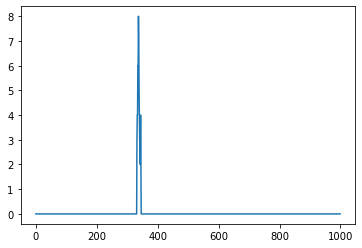

In [9]:
randIndex = np.random.randint(0, denoisedTrainWF.shape[0]-1)
# randIndex = 4388191 #
# randIndex = 4880157 #需要初始
# randIndex = 5886548 #太多了
# randIndex = 5186074
# randIndex = 3793364
# randIndex = 3218203
# randIndex = 690724
# randIndex = 3552877
# randIndex = 1070346
# randIndex = 157776
# randIndex = 5673090
cancelledWF = denoisedTrainWF[randIndex]
wfArgmax = getPePerWF(cancelledWF, pointsPerTrainWF[randIndex])
print(f"PE真值是{pePerTrainWF[randIndex]}")
print(f"积分是{intTrainWF[randIndex]}")
print(f"超出阈值的点是{pointsPerTrainWF[randIndex]}")
print(f"结果是{wfArgmax}")
plt.plot(denoisedTrainWF[randIndex])
plt.show()

下面检验三个feature对于真正的`pePerTrainWF`的关系，画出三个散点图：

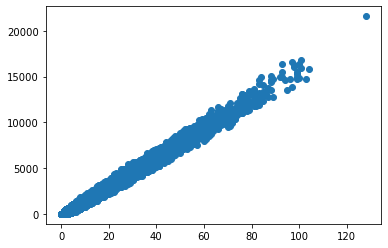

In [11]:
plt.scatter(pePerTrainWF, intTrainWF)
plt.show()

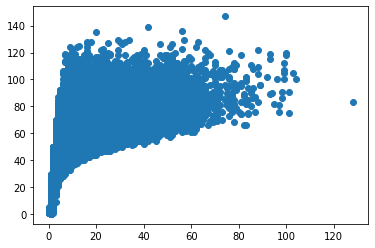

In [12]:
plt.scatter(pePerTrainWF, pointsPerTrainWF)
plt.show()

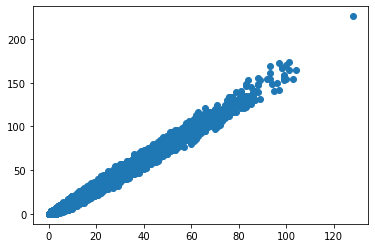

In [13]:
plt.scatter(pePerTrainWF, pePerTrainWFCalc)
plt.show()

用gbm，训练从以上三个feature到pePerTrainWF的模型：

In [30]:
trainDataForPePerWF = lgb.Dataset(
    np.stack(
        (intTrainWF[:-500000], pointsPerTrainWF[:-500000], pePerTrainWFCalc[:-500000]),
        axis=1
    ),
    label=pePerTrainWF[:-500000]
)
validationDataForPePerWF = lgb.Dataset(
    np.stack(
        (intTrainWF[-500000:], pointsPerTrainWF[-500000:], pePerTrainWFCalc[-500000:]),
        axis=1
    ),
    label=pePerTrainWF[-500000:],
    reference=trainDataForPePerWF
)
trainDataForPePerWF.save_binary('./train/trainPePerWF.bin')
validationDataForPePerWF.save_binary('./train/validPePerWF.bin')

[LightGBM] [Info] Saving data to binary file ./train/trainPePerWF.bin
[LightGBM] [Info] Saving data to binary file ./train/validPePerWF.bin


In [31]:
trainDataForPePerWF = lgb.Dataset('./train/trainPePerWF.bin')
validationDataForPePerWF = lgb.Dataset('./train/validPePerWF.bin', reference=trainDataForPePerWF)
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'rmse'},
    'num_leaves': 2**11,
    'learning_rate': 0.01,
    'feature_fraction': 1,
    'bagging_fraction': 1,
    'bagging_freq': 5,
    'verbose': 0,
    'num_threads': 20,
    'max_depth': 20,
}
gbmForPePerWF = lgb.train(
    params,
    trainDataForPePerWF,
    num_boost_round=3000,
    valid_sets=validationDataForPePerWF,
    early_stopping_rounds=300
)
gbmForPePerWF.save_model('modelPePerWF.txt')

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018826 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[1]	valid_0's rmse: 1.76336
Training until validation scores don't improve for 300 rounds
[2]	valid_0's rmse: 1.74613
[3]	valid_0's rmse: 1.72907
[4]	valid_0's rmse: 1.71219
[5]	valid_0's rmse: 1.69548
[6]	valid_0's rmse: 1.67894
[7]	valid_0's rmse: 1.66257
[8]	valid_0's rmse: 1.64637
[9]	valid_0's rmse: 1.63034
[10]	valid_0's rmse: 1.61448
[11]	valid_0's rmse: 1.59877
[12]	valid_0's rmse: 1.58323
[13]	valid_0's rmse: 1.56785
[14]	valid_0's rmse: 1.55263
[15]	valid_0's rmse: 1.53756
[16]	valid_0's rmse: 1.52265
[17]	valid_0's rmse: 1.50789
[18]	valid_0's rmse: 1.49329
[19]	valid_0's rmse: 1.47883
[20]	valid_0's rmse: 1.46453
[21]	valid_0's rmse: 1.45037
[22]	valid_0's rmse: 1.43636
[23]	valid_0's rmse: 1.4225
[24]	valid_0's rmse: 1.40878
[25]	valid_0's rmse: 1.

[263]	valid_0's rmse: 0.30122
[264]	valid_0's rmse: 0.300714
[265]	valid_0's rmse: 0.30022
[266]	valid_0's rmse: 0.299735
[267]	valid_0's rmse: 0.299257
[268]	valid_0's rmse: 0.298789
[269]	valid_0's rmse: 0.29833
[270]	valid_0's rmse: 0.29788
[271]	valid_0's rmse: 0.297439
[272]	valid_0's rmse: 0.297005
[273]	valid_0's rmse: 0.296581
[274]	valid_0's rmse: 0.296165
[275]	valid_0's rmse: 0.295753
[276]	valid_0's rmse: 0.295351
[277]	valid_0's rmse: 0.294957
[278]	valid_0's rmse: 0.294571
[279]	valid_0's rmse: 0.294192
[280]	valid_0's rmse: 0.293821
[281]	valid_0's rmse: 0.293455
[282]	valid_0's rmse: 0.293096
[283]	valid_0's rmse: 0.292747
[284]	valid_0's rmse: 0.2924
[285]	valid_0's rmse: 0.292063
[286]	valid_0's rmse: 0.291733
[287]	valid_0's rmse: 0.291406
[288]	valid_0's rmse: 0.291086
[289]	valid_0's rmse: 0.290774
[290]	valid_0's rmse: 0.29047
[291]	valid_0's rmse: 0.290167
[292]	valid_0's rmse: 0.289873
[293]	valid_0's rmse: 0.289582
[294]	valid_0's rmse: 0.289302
[295]	valid_0's

[529]	valid_0's rmse: 0.27591
[530]	valid_0's rmse: 0.275908
[531]	valid_0's rmse: 0.275908
[532]	valid_0's rmse: 0.275907
[533]	valid_0's rmse: 0.275906
[534]	valid_0's rmse: 0.275903
[535]	valid_0's rmse: 0.275901
[536]	valid_0's rmse: 0.2759
[537]	valid_0's rmse: 0.275899
[538]	valid_0's rmse: 0.275898
[539]	valid_0's rmse: 0.275897
[540]	valid_0's rmse: 0.275896
[541]	valid_0's rmse: 0.275895
[542]	valid_0's rmse: 0.275894
[543]	valid_0's rmse: 0.275893
[544]	valid_0's rmse: 0.275892
[545]	valid_0's rmse: 0.275891
[546]	valid_0's rmse: 0.27589
[547]	valid_0's rmse: 0.275889
[548]	valid_0's rmse: 0.275888
[549]	valid_0's rmse: 0.275887
[550]	valid_0's rmse: 0.275886
[551]	valid_0's rmse: 0.275885
[552]	valid_0's rmse: 0.275885
[553]	valid_0's rmse: 0.275884
[554]	valid_0's rmse: 0.275883
[555]	valid_0's rmse: 0.275883
[556]	valid_0's rmse: 0.275882
[557]	valid_0's rmse: 0.275882
[558]	valid_0's rmse: 0.275881
[559]	valid_0's rmse: 0.275881
[560]	valid_0's rmse: 0.27588
[561]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[750]	valid_0's rmse: 0.276084
[751]	valid_0's rmse: 0.276088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[752]	valid_0's rmse: 0.276092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[753]	valid_0's rmse: 0.276092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[754]	valid_0's rmse: 0.276092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[755]	valid_0's rmse: 0.276093
[756]	valid_0's rmse: 0.276093
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[757]	valid_0's rmse: 0.276092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[758]	valid_0's rmse: 0.276092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[759]	valid_0's rmse: 0.276091
[760]	valid_0's rmse: 0.276092
[761]	valid_0's rmse: 0.276094
[LightGBM] [Warning] No furt

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[840]	valid_0's rmse: 0.276218
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[841]	valid_0's rmse: 0.276219
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[842]	valid_0's rmse: 0.276221
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[843]	valid_0's rmse: 0.276222
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[844]	valid_0's rmse: 0.276225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[845]	valid_0's rmse: 0.276225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[846]	valid_0's rmse: 0.276228
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[847]	valid_0's rmse: 0.276229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[848]	valid_0's rmse: 0.276232
[LightGBM] [Warning] No further splits with po

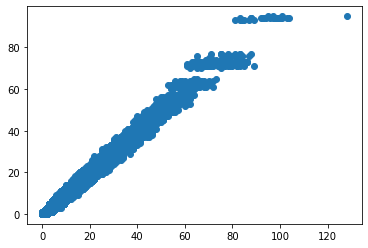

[320819 655803 169698]


In [39]:
pePerTrainWFFinal = gbmForPePerWF.predict(
    np.stack(
        (intTrainWF, pointsPerTrainWF, pePerTrainWFCalc),
        axis=1
    )
).astype(int)
plt.scatter(pePerTrainWF, pePerTrainWFFinal)
plt.show()
print(gbmForPePerWF.feature_importance())

In [88]:
splitPePerTrainWFFinal = np.split(pePerTrainWFFinal, wfIndices[1:-1])
peTotal = np.empty(2000)
peMean = np.empty(2000)
peStd = np.empty(2000)
for index, pePerTrainWFFinalChunk in enumerate(tqdm(splitPePerTrainWFFinal)):
    peTotal[index] = np.sum(pePerTrainWFFinalChunk)
    peMean[index] = np.mean(pePerTrainWFFinalChunk)
    peStd[index] = np.std(pePerTrainWFFinalChunk)

100%|██████████| 2000/2000 [00:00<00:00, 10670.18it/s]


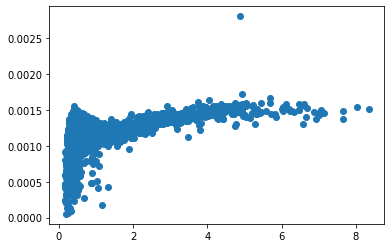

In [92]:
plt.scatter(peStd, trainPT['p']/peTotal)
plt.show()

In [96]:
trainDataForP = lgb.Dataset(
    np.stack(
        (peTotal[:-100], peMean[:-100], peStd[:-100]),
        axis=1
    ),
    label=trainPT[:-100]['p']
)
validationDataForP = lgb.Dataset(
    np.stack(
        (peTotal[-100:], peMean[-100:], peStd[-100:]),
        axis=1
    ),
    label=trainPT[-100:]['p'],
    reference=trainDataForP
)
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'rmse'},
    'num_leaves': 2**11,
    'learning_rate': 0.01,
    'feature_fraction': 1,
    'bagging_fraction': 1,
    'bagging_freq': 5,
    'verbose': 0,
    'num_threads': 20,
    'max_depth': 20,
}
gbmForP = lgb.train(
    params,
    trainDataForP,
    num_boost_round=3000,
    valid_sets=validationDataForP,
    early_stopping_rounds=300
)
gbmForP.save_model('modelP.txt')

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's rmse: 3.10266
Training until validation scores don't improve for 300 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's rmse: 3.07231
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's rmse: 3.04221
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's rmse: 3.01245
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's rmse: 2.98299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's rmse: 2.95386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]	valid_0's rmse: 2.92487
[LightGBM] [Warning] No further splits with positive

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[116]	valid_0's rmse: 1.0133
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[117]	valid_0's rmse: 1.00368
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[118]	valid_0's rmse: 0.994252
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[119]	valid_0's rmse: 0.984844
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[120]	valid_0's rmse: 0.975546
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[121]	valid_0's rmse: 0.966335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[122]	valid_0's rmse: 0.957281
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[123]	valid_0's rmse: 0.948278
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[124]	valid_0's rmse: 0.939337
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[194]	valid_0's rmse: 0.500379
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[195]	valid_0's rmse: 0.496265
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[196]	valid_0's rmse: 0.492154
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[197]	valid_0's rmse: 0.488015
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[198]	valid_0's rmse: 0.483994
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[199]	valid_0's rmse: 0.479963
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[200]	valid_0's rmse: 0.47602
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[201]	valid_0's rmse: 0.472099
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[202]	valid_0's rmse: 0.468243
[LightGBM] [Warning] No further splits with pos

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[303]	valid_0's rmse: 0.249416
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[304]	valid_0's rmse: 0.248418
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[305]	valid_0's rmse: 0.247445
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[306]	valid_0's rmse: 0.246477
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[307]	valid_0's rmse: 0.245519
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[308]	valid_0's rmse: 0.24458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[309]	valid_0's rmse: 0.24367
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[310]	valid_0's rmse: 0.242757
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[311]	valid_0's rmse: 0.241857
[LightGBM] [Warning] No further splits with posi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[417]	valid_0's rmse: 0.192199
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[418]	valid_0's rmse: 0.191947
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[419]	valid_0's rmse: 0.191696
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[420]	valid_0's rmse: 0.191447
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[421]	valid_0's rmse: 0.191206
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[422]	valid_0's rmse: 0.190961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[423]	valid_0's rmse: 0.190767
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[424]	valid_0's rmse: 0.190574
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[425]	valid_0's rmse: 0.19038
[LightGBM] [Warning] No further splits with pos

[526]	valid_0's rmse: 0.180386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[527]	valid_0's rmse: 0.180325
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[528]	valid_0's rmse: 0.180339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[529]	valid_0's rmse: 0.180216
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[530]	valid_0's rmse: 0.180159
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[531]	valid_0's rmse: 0.180097
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[532]	valid_0's rmse: 0.180048
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[533]	valid_0's rmse: 0.180038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[534]	valid_0's rmse: 0.179972
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[535]	valid_0's rmse: 0.179897
[LightGBM] [War

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[605]	valid_0's rmse: 0.177062
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[606]	valid_0's rmse: 0.177049
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[607]	valid_0's rmse: 0.176912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[608]	valid_0's rmse: 0.176763
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[609]	valid_0's rmse: 0.176675
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[610]	valid_0's rmse: 0.176533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[611]	valid_0's rmse: 0.176538
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[612]	valid_0's rmse: 0.176429
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[613]	valid_0's rmse: 0.176323
[LightGBM] [Warning] No further splits with po

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[703]	valid_0's rmse: 0.171389
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[704]	valid_0's rmse: 0.171361
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[705]	valid_0's rmse: 0.171316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[706]	valid_0's rmse: 0.17129
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[707]	valid_0's rmse: 0.171238
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[708]	valid_0's rmse: 0.171192
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[709]	valid_0's rmse: 0.171174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[710]	valid_0's rmse: 0.171123
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[711]	valid_0's rmse: 0.171065
[LightGBM] [Warning] No further splits with pos

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[852]	valid_0's rmse: 0.168632
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[853]	valid_0's rmse: 0.168623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[854]	valid_0's rmse: 0.168586
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[855]	valid_0's rmse: 0.168571
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[856]	valid_0's rmse: 0.16856
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[857]	valid_0's rmse: 0.16855
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[858]	valid_0's rmse: 0.168486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[859]	valid_0's rmse: 0.168471
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[860]	valid_0's rmse: 0.168463
[LightGBM] [Warning] No further splits with posi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[996]	valid_0's rmse: 0.16845
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[997]	valid_0's rmse: 0.168424
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[998]	valid_0's rmse: 0.168396
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[999]	valid_0's rmse: 0.168395
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1000]	valid_0's rmse: 0.168396
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1001]	valid_0's rmse: 0.168396
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1002]	valid_0's rmse: 0.168402
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1003]	valid_0's rmse: 0.168441
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1004]	valid_0's rmse: 0.168442
[LightGBM] [Warning] No further splits wit

[1123]	valid_0's rmse: 0.169068
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1124]	valid_0's rmse: 0.169046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1125]	valid_0's rmse: 0.16902
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1126]	valid_0's rmse: 0.169077
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1127]	valid_0's rmse: 0.169057
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1128]	valid_0's rmse: 0.169043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1129]	valid_0's rmse: 0.169039
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1130]	valid_0's rmse: 0.169042
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1131]	valid_0's rmse: 0.169041
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1132]	valid_0's rmse: 0.169049
[Light

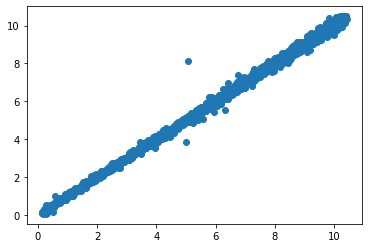

In [99]:
plt.scatter(
    gbmForP.predict(
        np.stack(
            (peTotal, peMean, peStd),
            axis=1
        )
    ),
    trainPT['p']
)

In [85]:
splitPePerTrainWFFinal = np.split(pePerTrainWFFinal, wfIndices[1:-1])
featuresForXYZ = np.empty((2000, 4))
channelsMostPe = np.empty((2000, 3), dtype=int)
for index, pePerTrainWFFinalChunk in enumerate(tqdm(splitPePerTrainWFFinal)):
    channelsMostPe[index] = np.argsort(pePerTrainWFFinalChunk)[-3:]
    featuresForXYZ[index] = [
        np.cos(geo[channelsMostPe[index, 0]]['theta']/180*np.pi), 
        np.sin(geo[channelsMostPe[index, 0]]['phi']/180*np.pi), 
        pePerTrainWFFinal[channelsMostPe[index, 0]],
        meanPeTimePerTrainWF[channelsMostPe[index, 0]]*300,
        #geo[channelsMostPe[index, 1]]['theta'], 
        #geo[channelsMostPe[index, 1]]['phi'], 
        #pePerTrainWFFinal[channelsMostPe[index, 1]],
        #meanPeTimePerTrainWF[channelsMostPe[index, 1]],
        #geo[channelsMostPe[index, 2]]['theta'], 
        #geo[channelsMostPe[index, 2]]['phi'], 
        #pePerTrainWFFinal[channelsMostPe[index, 2]],
        #meanPeTimePerTrainWF[channelsMostPe[index, 2]]
    ]
    

trainDataForX = lgb.Dataset(
    featuresForXYZ[:-200],
    label=trainPT['x'][:-200]
)
validationDataForX = lgb.Dataset(
    featuresForXYZ[-200:],
    label=trainPT['x'][-200:],
    reference=trainDataForX
)
trainDataForX.save_binary('./train/trainX.bin')
validationDataForX.save_binary('./train/validX.bin')

trainDataForY = lgb.Dataset(
    featuresForXYZ[:-200],
    label=trainPT['y'][:-200]
)
validationDataForY = lgb.Dataset(
    featuresForXYZ[-200:],
    label=trainPT['y'][-200:],
    reference=trainDataForY
)
trainDataForY.save_binary('./train/trainY.bin')
validationDataForY.save_binary('./train/validY.bin')

trainDataForZ = lgb.Dataset(
    featuresForXYZ[:-200],
    label=trainPT['z'][:-200]
)
validationDataForZ = lgb.Dataset(
    featuresForXYZ[-200:],
    label=trainPT['z'][-200:],
    reference=trainDataForZ
)
trainDataForZ.save_binary('./train/trainZ.bin')
validationDataForZ.save_binary('./train/validZ.bin')

100%|██████████| 2000/2000 [00:00<00:00, 14024.47it/s]

[LightGBM] [Info] Saving data to binary file ./train/trainX.bin
[LightGBM] [Info] Saving data to binary file ./train/validX.bin
[LightGBM] [Warning] File ./train/trainY.bin exists, cannot save binary to it
[LightGBM] [Warning] File ./train/validY.bin exists, cannot save binary to it
[LightGBM] [Warning] File ./train/trainZ.bin exists, cannot save binary to it
[LightGBM] [Warning] File ./train/validZ.bin exists, cannot save binary to it


In [86]:
trainDataForX = lgb.Dataset('./train/trainX.bin')
validationDataForX = lgb.Dataset('./train/validX.bin', reference=trainDataForX)
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'rmse'},
    'num_leaves': 2**15,
    'learning_rate': 0.001,
    'feature_fraction': 1,
    'bagging_fraction': 1,
    'bagging_freq': 5,
    'verbose': 0,
    'num_threads': 20,
    'max_depth': 500,
}
gbmForX = lgb.train(
    params,
    trainDataForX,
    num_boost_round=3000,
    valid_sets=validationDataForX,
    early_stopping_rounds=300
)
gbmForX.save_model('modelX.txt')

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's rmse: 7714.61
Training until validation scores don't improve for 300 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's rmse: 7714.83
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's rmse: 7715.06
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's rmse: 7715.27
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's rmse: 7715.5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's rmse: 7715.72
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]	valid_0's rmse: 7715.94
[LightGBM] [Warning] No further splits with positive 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[84]	valid_0's rmse: 7731.27
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[85]	valid_0's rmse: 7731.5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[86]	valid_0's rmse: 7731.69
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[87]	valid_0's rmse: 7731.86
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[88]	valid_0's rmse: 7732.08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[89]	valid_0's rmse: 7732.26
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[90]	valid_0's rmse: 7732.47
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[91]	valid_0's rmse: 7732.7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[92]	valid_0's rmse: 7732.83
[LightGBM] [Warning] No further splits with positive gain, best ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[176]	valid_0's rmse: 7748.36
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[177]	valid_0's rmse: 7748.52
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[178]	valid_0's rmse: 7748.66
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[179]	valid_0's rmse: 7748.82
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[180]	valid_0's rmse: 7748.98
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[181]	valid_0's rmse: 7749.02
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[182]	valid_0's rmse: 7749.16
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[183]	valid_0's rmse: 7749.32
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[184]	valid_0's rmse: 7749.47
[LightGBM] [Warning] No further splits with positive ga

[268]	valid_0's rmse: 7761.51
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[269]	valid_0's rmse: 7761.48
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[270]	valid_0's rmse: 7761.76
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[271]	valid_0's rmse: 7761.79
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[272]	valid_0's rmse: 7762.08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[273]	valid_0's rmse: 7762.11
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[274]	valid_0's rmse: 7762.07
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[275]	valid_0's rmse: 7762.32
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[276]	valid_0's rmse: 7762.36
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[277]	valid_0's rmse: 7762.33
[LightGBM] [Warning] No f

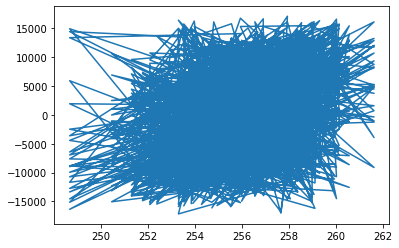

In [87]:
plt.plot(gbmForX.predict(featuresForXYZ), trainPT['x'])
plt.show()

In [708]:
from hyperopt import fmin, tpe, hp
best = fmin(
    fn=getPETime,
    space=[
        hp.uniform('point_judge', 0, 10),
        hp.uniform('int_judge', 60, 200),
        hp.uniform('cancel_max', 10, 25),
        hp.uniform('noise_thre', 0, 10),
        hp.uniform('point_minus', 10, 30),
        hp.uniform('int_minus', 100, 200),
    ],
    algo=tpe.suggest,
    max_evals=100)
print(best)

  3%|▎         | 3/100 [00:03<01:54,  1.18s/trial, best loss: -8661.0]


KeyboardInterrupt: 

In [26]:
saveData(X1, trainPT, './train/train1.h5')

In [27]:
X1, Y1 = loadData('./data/train1.h5', 'pro')

OSError: Unable to open file (unable to open file: name = './data/train1.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [28]:
train_data1 = lgb.Dataset(X1[:-100], label=Y1[:-100])
validation_data1 = lgb.Dataset(np.array(X1[-100:]), np.array(Y1[-100:]), reference=train_data1)
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'rmse'},
    'num_leaves': 2**11,
    'learning_rate': 0.01,
    'feature_fraction': 1,
    'bagging_fraction': 1,
    'bagging_freq': 5,
    'verbose': 0,
    'num_threads': 20,
    'max_depth': 11,
}
gbm1 = lgb.train(params,
                 train_data1,
                 num_boost_round=3000,
                 valid_sets=validation_data1,
                 early_stopping_rounds=300)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's rmse: 14727.9
Training until validation scores don't improve for 300 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's rmse: 14582.1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's rmse: 14437.9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's rmse: 14295.3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's rmse: 14153.9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's rmse: 14014.4
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]	valid_0's rmse: 13875.8
[LightGBM] [Warning] No further splits with positive

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[169]	valid_0's rmse: 2950.77
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[170]	valid_0's rmse: 2924.87
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[171]	valid_0's rmse: 2899.22
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[172]	valid_0's rmse: 2873.91
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[173]	valid_0's rmse: 2848.92
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[174]	valid_0's rmse: 2824.21
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[175]	valid_0's rmse: 2799.74
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[176]	valid_0's rmse: 2775.4
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[177]	valid_0's rmse: 2751.25
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[253]	valid_0's rmse: 1549.75
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[254]	valid_0's rmse: 1540.36
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[255]	valid_0's rmse: 1531
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[256]	valid_0's rmse: 1521.8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[257]	valid_0's rmse: 1512.88
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[258]	valid_0's rmse: 1503.8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[259]	valid_0's rmse: 1495.06
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[260]	valid_0's rmse: 1486.12
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[261]	valid_0's rmse: 1477.29
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[341]	valid_0's rmse: 1060.57
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[342]	valid_0's rmse: 1057.77
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[343]	valid_0's rmse: 1055.07
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[344]	valid_0's rmse: 1052.28
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[345]	valid_0's rmse: 1049.68
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[346]	valid_0's rmse: 1047.09
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[347]	valid_0's rmse: 1044.38
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[348]	valid_0's rmse: 1041.94
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[349]	valid_0's rmse: 1039.36
[LightGBM] [Warning] No further splits with positive ga

[420]	valid_0's rmse: 940.729
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[421]	valid_0's rmse: 939.961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[422]	valid_0's rmse: 939.336
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[423]	valid_0's rmse: 938.413
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[424]	valid_0's rmse: 937.611
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[425]	valid_0's rmse: 937.007
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[426]	valid_0's rmse: 936.053
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[427]	valid_0's rmse: 935.584
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[428]	valid_0's rmse: 934.72
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[429]	valid_0's rmse: 934.266
[LightGBM] [Warning] No fu

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[514]	valid_0's rmse: 905.912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[515]	valid_0's rmse: 905.828
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[516]	valid_0's rmse: 905.415
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[517]	valid_0's rmse: 905.399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[518]	valid_0's rmse: 905.308
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[519]	valid_0's rmse: 904.768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[520]	valid_0's rmse: 904.681
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[521]	valid_0's rmse: 904.595
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[522]	valid_0's rmse: 904.406
[LightGBM] [Warning] No further splits with positive ga

[601]	valid_0's rmse: 891.506
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[602]	valid_0's rmse: 891.62
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[603]	valid_0's rmse: 891.737
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[604]	valid_0's rmse: 891.852
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[605]	valid_0's rmse: 891.996
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[606]	valid_0's rmse: 892.116
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[607]	valid_0's rmse: 892.251
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[608]	valid_0's rmse: 892.432
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[609]	valid_0's rmse: 892.446
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[610]	valid_0's rmse: 892.458
[LightGBM] [Warning] No fu

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[724]	valid_0's rmse: 885.606
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[725]	valid_0's rmse: 885.645
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[726]	valid_0's rmse: 885.566
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[727]	valid_0's rmse: 885.574
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[728]	valid_0's rmse: 885.397
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[729]	valid_0's rmse: 885.396
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[730]	valid_0's rmse: 885.319
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[731]	valid_0's rmse: 885.242
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[732]	valid_0's rmse: 885.167
[LightGBM] [Warning] No further splits with positive ga

[877]	valid_0's rmse: 884.897
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[878]	valid_0's rmse: 884.885
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[879]	valid_0's rmse: 885.026
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[880]	valid_0's rmse: 884.908
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[881]	valid_0's rmse: 884.896
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[882]	valid_0's rmse: 884.865
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[883]	valid_0's rmse: 884.719
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[884]	valid_0's rmse: 884.739
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[885]	valid_0's rmse: 884.821
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[886]	valid_0's rmse: 884.903
[LightGBM] [Warning] No f

[1033]	valid_0's rmse: 885.741
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1034]	valid_0's rmse: 885.837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1035]	valid_0's rmse: 885.712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1036]	valid_0's rmse: 885.724
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1037]	valid_0's rmse: 885.729
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1038]	valid_0's rmse: 885.827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1039]	valid_0's rmse: 885.708
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1040]	valid_0's rmse: 885.75
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1041]	valid_0's rmse: 885.646
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1042]	valid_0's rmse: 885.651
[LightGBM] [Warn

In [29]:
X2 = np.hstack((X1, gbm1.predict(X1).reshape(-1,1)))
Y2 = numPET

In [30]:
train_data2 = lgb.Dataset(X2[:-100], label=Y2[:-100])
validation_data2 = lgb.Dataset(np.array(X2[-100:]), np.array(Y2[-100:]), reference=train_data2)
gbm2 = lgb.train(params,
                train_data2,
                num_boost_round=3000,
                valid_sets=validation_data2,
                early_stopping_rounds=300)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's rmse: 2322.35
Training until validation scores don't improve for 300 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's rmse: 2299.43
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's rmse: 2276.69
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's rmse: 2254.2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's rmse: 2231.97
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's rmse: 2209.85
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]	valid_0's rmse: 2188
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[151]	valid_0's rmse: 530.883
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[152]	valid_0's rmse: 525.768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[153]	valid_0's rmse: 520.712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[154]	valid_0's rmse: 515.711
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[155]	valid_0's rmse: 510.743
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[156]	valid_0's rmse: 505.843
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[157]	valid_0's rmse: 500.981
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[158]	valid_0's rmse: 496.197
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[159]	valid_0's rmse: 491.407
[LightGBM] [Warning] No further splits with positive ga

[237]	valid_0's rmse: 235.87
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[238]	valid_0's rmse: 233.75
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[239]	valid_0's rmse: 231.678
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[240]	valid_0's rmse: 229.605
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[241]	valid_0's rmse: 227.572
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[242]	valid_0's rmse: 225.552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[243]	valid_0's rmse: 223.564
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[244]	valid_0's rmse: 221.593
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[245]	valid_0's rmse: 219.653
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[246]	valid_0's rmse: 217.687
[LightGBM] [Warning] No fur

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[323]	valid_0's rmse: 118.188
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[324]	valid_0's rmse: 117.408
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[325]	valid_0's rmse: 116.643
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[326]	valid_0's rmse: 115.879
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[327]	valid_0's rmse: 115.132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[328]	valid_0's rmse: 114.407
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[329]	valid_0's rmse: 113.666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[330]	valid_0's rmse: 112.948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[331]	valid_0's rmse: 112.221
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[481]	valid_0's rmse: 66.9265
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[482]	valid_0's rmse: 66.8608
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[483]	valid_0's rmse: 66.7728
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[484]	valid_0's rmse: 66.668
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[485]	valid_0's rmse: 66.6106
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[486]	valid_0's rmse: 66.5053
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[487]	valid_0's rmse: 66.4326
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[488]	valid_0's rmse: 66.3651
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[489]	valid_0's rmse: 66.2752
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[563]	valid_0's rmse: 62.6469
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[564]	valid_0's rmse: 62.6133
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[565]	valid_0's rmse: 62.5848
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[566]	valid_0's rmse: 62.5531
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[567]	valid_0's rmse: 62.5283
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[568]	valid_0's rmse: 62.4992
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[569]	valid_0's rmse: 62.4778
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[570]	valid_0's rmse: 62.4533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[571]	valid_0's rmse: 62.4282
[LightGBM] [Warning] No further splits with positive ga

[652]	valid_0's rmse: 60.6443
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[653]	valid_0's rmse: 60.6433
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[654]	valid_0's rmse: 60.6287
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[655]	valid_0's rmse: 60.616
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[656]	valid_0's rmse: 60.5887
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[657]	valid_0's rmse: 60.5684
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[658]	valid_0's rmse: 60.5537
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[659]	valid_0's rmse: 60.526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[660]	valid_0's rmse: 60.5099
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[661]	valid_0's rmse: 60.4979
[LightGBM] [Warning] No fur

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[765]	valid_0's rmse: 59.5018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[766]	valid_0's rmse: 59.4968
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[767]	valid_0's rmse: 59.513
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[768]	valid_0's rmse: 59.5074
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[769]	valid_0's rmse: 59.5223
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[770]	valid_0's rmse: 59.514
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[771]	valid_0's rmse: 59.5264
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[772]	valid_0's rmse: 59.5408
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[773]	valid_0's rmse: 59.5356
[LightGBM] [Warning] No further splits with positive gain

[923]	valid_0's rmse: 59.333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[924]	valid_0's rmse: 59.3332
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[925]	valid_0's rmse: 59.3413
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[926]	valid_0's rmse: 59.3415
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[927]	valid_0's rmse: 59.3498
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[928]	valid_0's rmse: 59.3472
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[929]	valid_0's rmse: 59.3506
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[930]	valid_0's rmse: 59.3539
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[931]	valid_0's rmse: 59.3641
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[932]	valid_0's rmse: 59.3681
[LightGBM] [Warning] No fu

[1121]	valid_0's rmse: 59.1897
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1122]	valid_0's rmse: 59.1877
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1123]	valid_0's rmse: 59.194
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1124]	valid_0's rmse: 59.1877
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1125]	valid_0's rmse: 59.1854
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1126]	valid_0's rmse: 59.1899
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1127]	valid_0's rmse: 59.1857
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1128]	valid_0's rmse: 59.1837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1129]	valid_0's rmse: 59.1891
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1130]	valid_0's rmse: 59.1869
[LightGBM] [Warn

[1335]	valid_0's rmse: 59.1487
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1336]	valid_0's rmse: 59.1514
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1337]	valid_0's rmse: 59.1529
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1338]	valid_0's rmse: 59.1497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1339]	valid_0's rmse: 59.1518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1340]	valid_0's rmse: 59.1534
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1341]	valid_0's rmse: 59.1528
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1342]	valid_0's rmse: 59.1549
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1343]	valid_0's rmse: 59.1542
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1344]	valid_0's rmse: 59.1544
[LightGBM] [War

[1543]	valid_0's rmse: 59.3255
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1544]	valid_0's rmse: 59.3276
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1545]	valid_0's rmse: 59.3319
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1546]	valid_0's rmse: 59.3285
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1547]	valid_0's rmse: 59.3318
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1548]	valid_0's rmse: 59.3402
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1549]	valid_0's rmse: 59.3411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1550]	valid_0's rmse: 59.34
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1551]	valid_0's rmse: 59.341
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1552]	valid_0's rmse: 59.338
[LightGBM] [Warning

In [31]:
X = np.hstack((X2, gbm2.predict(X2).reshape(-1,1)))
# X = X2
Y = trainPT['p']/1-np.exp(-trainPT['vis_photons'])


In [32]:
train_data = lgb.Dataset(np.array(X[:-100]), label=np.array(Y[:-100]))
validation_data = lgb.Dataset(np.array(X[-100:]), np.array(Y[-100:]), reference=train_data)
gbm = lgb.train(params,
                train_data,
                num_boost_round=3000,
                valid_sets=validation_data,
                early_stopping_rounds=300)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's rmse: 3.10241
Training until validation scores don't improve for 300 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's rmse: 3.07174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's rmse: 3.04135
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's rmse: 3.01128
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's rmse: 2.98151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's rmse: 2.95203
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]	valid_0's rmse: 2.92286
[LightGBM] [Warning] No further splits with positive

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[152]	valid_0's rmse: 0.722489
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[153]	valid_0's rmse: 0.71599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[154]	valid_0's rmse: 0.709544
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[155]	valid_0's rmse: 0.703146
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[156]	valid_0's rmse: 0.696847
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[157]	valid_0's rmse: 0.690685
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[158]	valid_0's rmse: 0.684491
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[159]	valid_0's rmse: 0.678393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[160]	valid_0's rmse: 0.672338
[LightGBM] [Warning] No further splits with pos

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[236]	valid_0's rmse: 0.364633
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[237]	valid_0's rmse: 0.362171
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[238]	valid_0's rmse: 0.359695
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[239]	valid_0's rmse: 0.35726
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[240]	valid_0's rmse: 0.354902
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[241]	valid_0's rmse: 0.352543
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[242]	valid_0's rmse: 0.350229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[243]	valid_0's rmse: 0.347935
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[244]	valid_0's rmse: 0.345669
[LightGBM] [Warning] No further splits with pos

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[320]	valid_0's rmse: 0.23855
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[321]	valid_0's rmse: 0.237746
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[322]	valid_0's rmse: 0.237005
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[323]	valid_0's rmse: 0.236308
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[324]	valid_0's rmse: 0.23554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[325]	valid_0's rmse: 0.234778
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[326]	valid_0's rmse: 0.234036
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[327]	valid_0's rmse: 0.233321
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[328]	valid_0's rmse: 0.23257
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[406]	valid_0's rmse: 0.202573
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[407]	valid_0's rmse: 0.202356
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[408]	valid_0's rmse: 0.202127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[409]	valid_0's rmse: 0.202
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[410]	valid_0's rmse: 0.201774
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[411]	valid_0's rmse: 0.201541
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[412]	valid_0's rmse: 0.201402
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[413]	valid_0's rmse: 0.201237
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[414]	valid_0's rmse: 0.201035
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[496]	valid_0's rmse: 0.194124
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[497]	valid_0's rmse: 0.194046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[498]	valid_0's rmse: 0.194007
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[499]	valid_0's rmse: 0.193946
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[500]	valid_0's rmse: 0.193846
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[501]	valid_0's rmse: 0.193809
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[502]	valid_0's rmse: 0.19377
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[503]	valid_0's rmse: 0.193691
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[504]	valid_0's rmse: 0.193641
[LightGBM] [Warning] No further splits with pos

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[600]	valid_0's rmse: 0.191811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[601]	valid_0's rmse: 0.191773
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[602]	valid_0's rmse: 0.191786
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[603]	valid_0's rmse: 0.191778
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[604]	valid_0's rmse: 0.191785
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[605]	valid_0's rmse: 0.191798
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[606]	valid_0's rmse: 0.191799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[607]	valid_0's rmse: 0.191802
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[608]	valid_0's rmse: 0.191766
[LightGBM] [Warning] No further splits with po

[728]	valid_0's rmse: 0.191309
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[729]	valid_0's rmse: 0.191271
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[730]	valid_0's rmse: 0.191276
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[731]	valid_0's rmse: 0.191269
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[732]	valid_0's rmse: 0.191267
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[733]	valid_0's rmse: 0.191239
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[734]	valid_0's rmse: 0.191219
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[735]	valid_0's rmse: 0.191214
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[736]	valid_0's rmse: 0.191198
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[737]	valid_0's rmse: 0.191185
[LightGBM] [War

[894]	valid_0's rmse: 0.1911
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[895]	valid_0's rmse: 0.191091
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[896]	valid_0's rmse: 0.19107
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[897]	valid_0's rmse: 0.191055
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[898]	valid_0's rmse: 0.19104
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[899]	valid_0's rmse: 0.191028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[900]	valid_0's rmse: 0.191008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[901]	valid_0's rmse: 0.191013
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[902]	valid_0's rmse: 0.190995
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[903]	valid_0's rmse: 0.190984
[LightGBM] [Warning

[1076]	valid_0's rmse: 0.191243
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1077]	valid_0's rmse: 0.191247
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1078]	valid_0's rmse: 0.191259
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1079]	valid_0's rmse: 0.191267
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1080]	valid_0's rmse: 0.19125
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1081]	valid_0's rmse: 0.191269
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1082]	valid_0's rmse: 0.191278
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1083]	valid_0's rmse: 0.191269
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1084]	valid_0's rmse: 0.19127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1085]	valid_0's rmse: 0.191266
[LightG

[1255]	valid_0's rmse: 0.191225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1256]	valid_0's rmse: 0.191255
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1257]	valid_0's rmse: 0.191266
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1258]	valid_0's rmse: 0.19127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1259]	valid_0's rmse: 0.191282
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1260]	valid_0's rmse: 0.191281
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1261]	valid_0's rmse: 0.191283
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1262]	valid_0's rmse: 0.191263
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1263]	valid_0's rmse: 0.191255
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1264]	valid_0's rmse: 0.191262
[Light

In [196]:
Xtest = np.hstack((numPEWtest.reshape(-1, 1), intWFtest.reshape(-1, 1)))
Xt1 = np.hstack((Xtest, gbm1.predict(Xtest).reshape(-1,1)))
Xt = np.hstack((Xt1, gbm2.predict(Xt1).reshape(-1,1)))
# Xt = Xt1

In [195]:
from pynverse import inversefunc
trans = lambda x: x/1-np.exp(-x)
invtrans = inversefunc(trans)

In [197]:
ans_gbm = invtrans(gbm.predict(Xt))
expname = 'dGBM'
saveans(ans_gbm, './ans/'+expname+'.h5')

In [198]:
trainPET

array([[ 0.00000000e+00,  4.00000000e+00,  6.00022656e+02,
         1.00000000e+00],
       [ 0.00000000e+00,  8.00000000e+00,  6.04903013e+02,
         1.00000000e+00],
       [ 0.00000000e+00,  1.10000000e+01,  5.76875682e+02,
         1.00000000e+00],
       ...,
       [ 1.99900000e+03,  1.75810000e+04,  6.01051849e+02,
         1.00000000e+00],
       [ 1.99900000e+03,  1.76070000e+04,  5.86866675e+02,
         1.00000000e+00],
       [ 1.99900000e+03,  1.76090000e+04,  6.40730998e+01,
        -1.00000000e+00]])

In [135]:
gbm1.feature_importance()

array([22543, 16897], dtype=int32)

In [10]:
trainPT[:, -1]

array([18971., 23288., 41752., ..., 10660., 12040., 11545.])

In [33]:
# plt.scatter(trainPT[:, -1], numPEW)
# plt.scatter(trainPT[:, -1], numPET)
# plt.scatter(trainPT[:, -1], numPET1)
# plt.scatter(trainPT[:, -1], intWF/trainPT[:, -1])
# plt.scatter(trainPT[:, -2], trainPT[:,-2]/intWF)
# plt.scatter(gbm.predict(X), gbm.predict(X)/intWF)
# plt.scatter(np.log(trainPT[:, -2]+1), trainPT[:,-2]/numPEW)
# plt.scatter(np.log(gbm.predict(X)+1), gbm.predict(X)/numPEW)
plt.scatter(trainPT[:, -2]/np.log(trainPT[:, -2]+1), numPEW)
plt.scatter(gbm.predict(X), numPEW)
#plt.scatter(trainPT[:10, -1], trainPT[:10, -2]*1000)
# plt.scatter(gbm1.predict(X1), intWF/100)
#plt.scatter(trainPT[:10, -1], gbm.predict(X)[:10]*1000)
#plt.scatter(numPEW, numPET)
plt.show()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

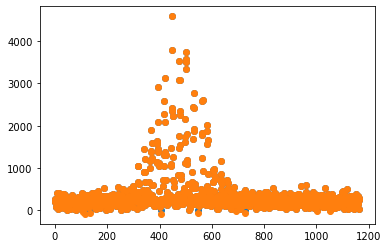

In [142]:
arr = invTrainWF[3085221:3086386]
head = np.mean(arr[:, :100], axis=1)
tail = np.mean(arr[:, -100:], axis=1)
base = np.minimum(head, tail)
intWF0 = np.sum(arr, axis=1)-base*1000
plt.scatter(range(3086386-3085221),  (np.abs(intWF0)+intWF0)/2)
plt.scatter(range(3086386-3085221),  intWF0)
plt.show()

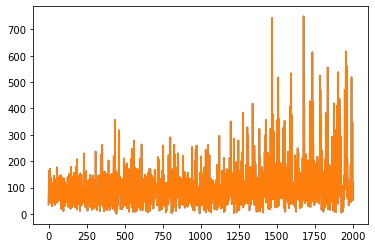

In [34]:
arr = invTrainWF[:2000]
head = np.mean(arr[:, :100], axis=1)
tail = np.mean(arr[:, -100:], axis=1)
base = np.minimum(head, tail)
intWF0 = np.sum(arr, axis=1)-base*1000
plt.plot(range(2000),  (np.abs(intWF0)+intWF0)/2)
plt.plot(range(2000),  intWF0)
plt.show()

In [135]:
np.argmin(intWF0)

2414

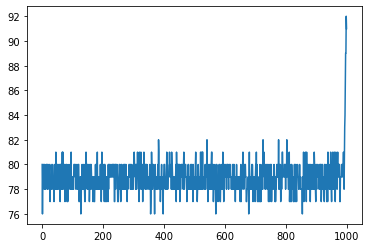

In [136]:
plt.plot(invTrainWF[2414])

In [85]:
j_tru[1007], j_tru[1008]

(3085221, 3086386)

In [17]:
X1

array([18971., 23288., 41752., ..., 10660., 12040., 11545.])